In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
import shap
import pickle
import cloudpickle
import numpy as np
from comparers import ModelComparer
from explainers import generate_shap_explanations
from plots import plot_decision_boundary, plot_2d, plot_feature_importance_bar, plot_feature_importance_scatter,\
                  plot_feature_effects, plot_forces
from util import calc_feature_order, calc_class_order, calc_instance_order
shap.initjs()
%matplotlib inline
task_name = '01'

In [2]:
try:
    with open(task_name + '.models', 'rb') as f:
        comparer = pickle.load(f)
    with open(task_name + '.expl', 'rb') as f:
        explanations = pickle.load(f)
    print('loaded saved state')
except FileNotFoundError:
    pass

# Setup Task

In [3]:
X, y = shap.datasets.iris()
feature_names = X.columns.to_numpy()
n_features = len(feature_names)
X = X.to_numpy()
n_samples = X.shape[0]

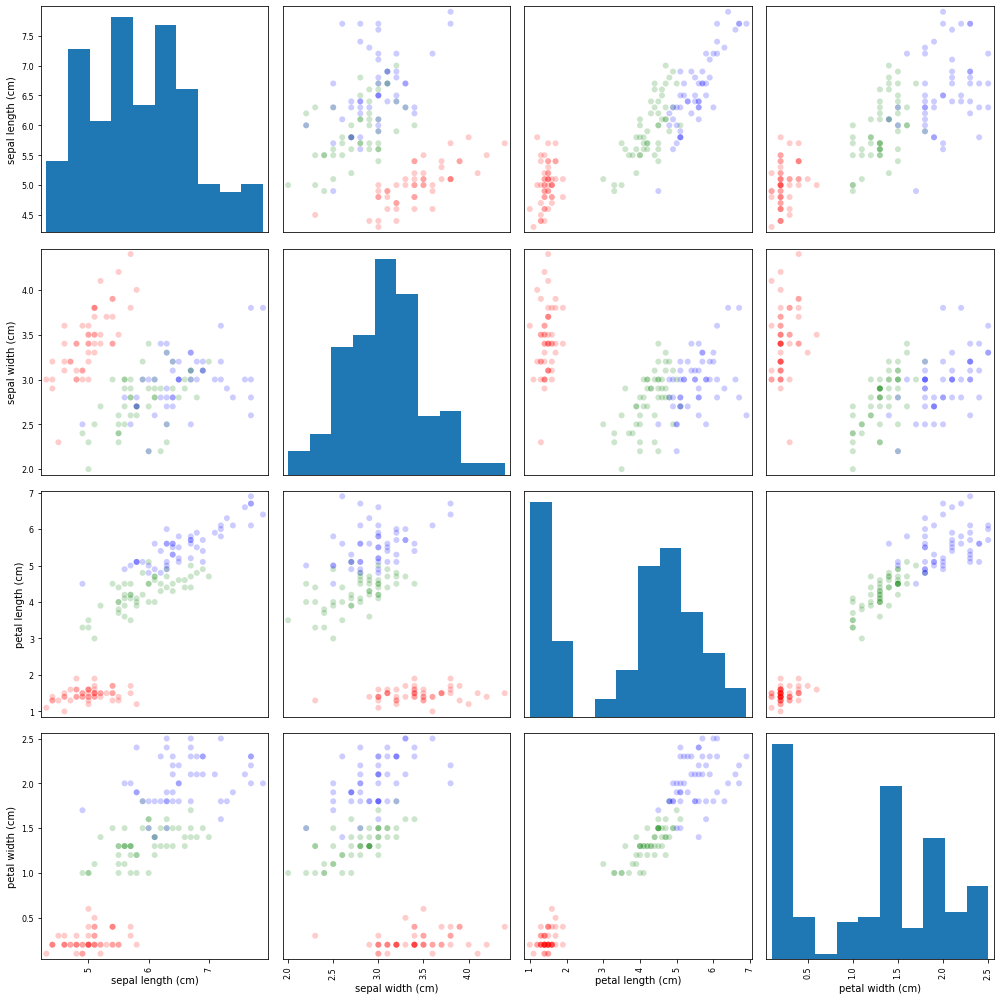

In [15]:
import pandas as pd
df = pd.DataFrame(X, columns=feature_names)
colors = np.repeat('r', df.shape[0])
colors[y == 1] = 'g'
colors[y == 2] = 'b'
axes = pd.plotting.scatter_matrix(df, figsize=(14, 14), marker='o', alpha=0.2, c=colors)
plt.tight_layout()

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=52)

In [10]:
from sklearn.linear_model import LogisticRegression
lm = LogisticRegression(C=1.0, max_iter=10000)
lm.fit(X_train, y_train)
lm.intercept_, lm.coef_

(array([  9.44752362,   1.72316583, -11.17068945]),
 array([[-0.41334231,  0.88077623, -2.36121068, -1.03733945],
        [ 0.53647604, -0.26579154, -0.16268626, -0.90500673],
        [-0.12313374, -0.61498469,  2.52389694,  1.94234618]]))

In [11]:
clf_a = lm

In [26]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

class ModifiedClassifier(BaseEstimator, ClassifierMixin):
    
    def  __init__(self, base_model):
         self.base_model = base_model
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.classes_ = unique_labels(y)
        return self
    
    def predict(self, X):
        y = self.base_model.predict(X)
        y[(X[:, 2] > 4.5) & (y == 1)] = 2
        return y
    
clf_b = ModifiedClassifier(lm)
clf_b.fit(X, y)

ModifiedClassifier(base_model=LogisticRegression(max_iter=10000))

In [27]:
comparer = ModelComparer(clf_a, clf_b, feature_names)
comparer.fit(X, y)
with open(task_name + '.models', 'wb') as f:
    cloudpickle.dump(comparer, f, pickle.HIGHEST_PROTOCOL)

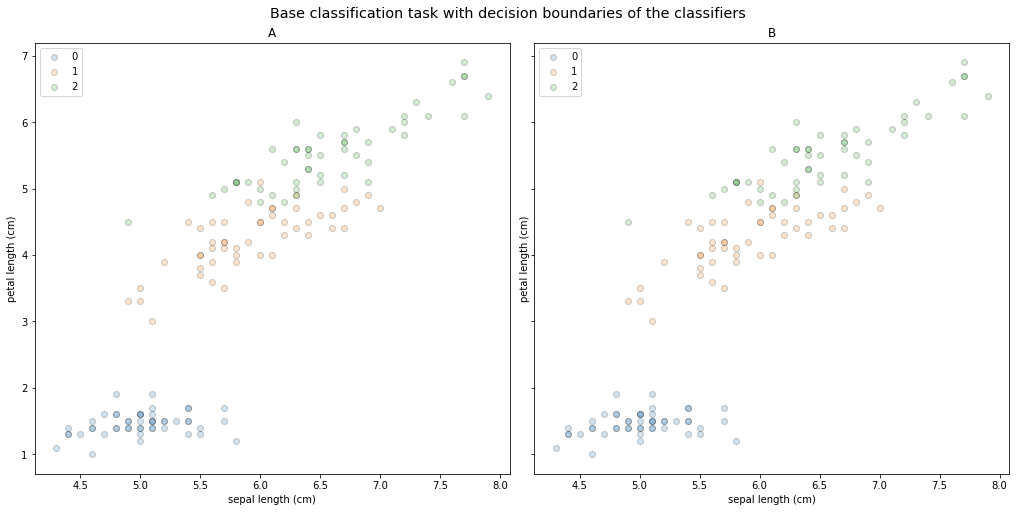

In [28]:
comparer.plot_individual_clf_decision_boundaries(X, y_true=y, kind='label', idx_x=0, idx_y=2, alpha=0.2)

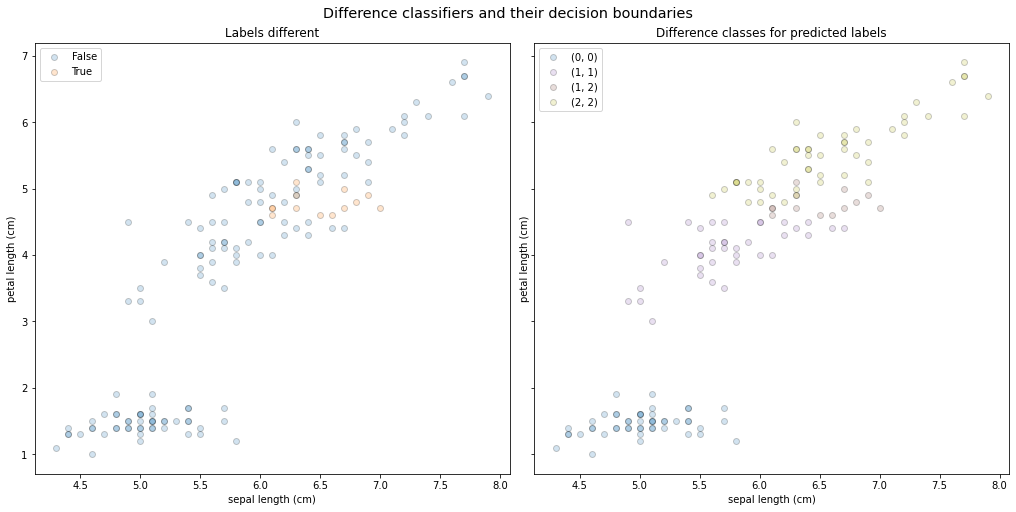

In [29]:
comparer.plot_decision_boundaries(X, idx_x=0, idx_y=2, alpha=0.2)

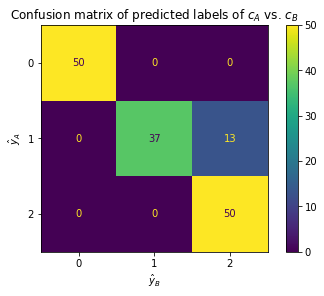

In [30]:
comparer.plot_confusion_matrix(X)

# Explain using Interpretability Methods

In [31]:
%%time
explanations = generate_shap_explanations(comparer, X, space_types=['labels'])
with open(task_name + '.expl', 'wb') as f:
    pickle.dump(explanations, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 5.49 s, sys: 83.3 ms, total: 5.57 s
Wall time: 5.73 s


## Visualize SHAP values

### Individual explanations

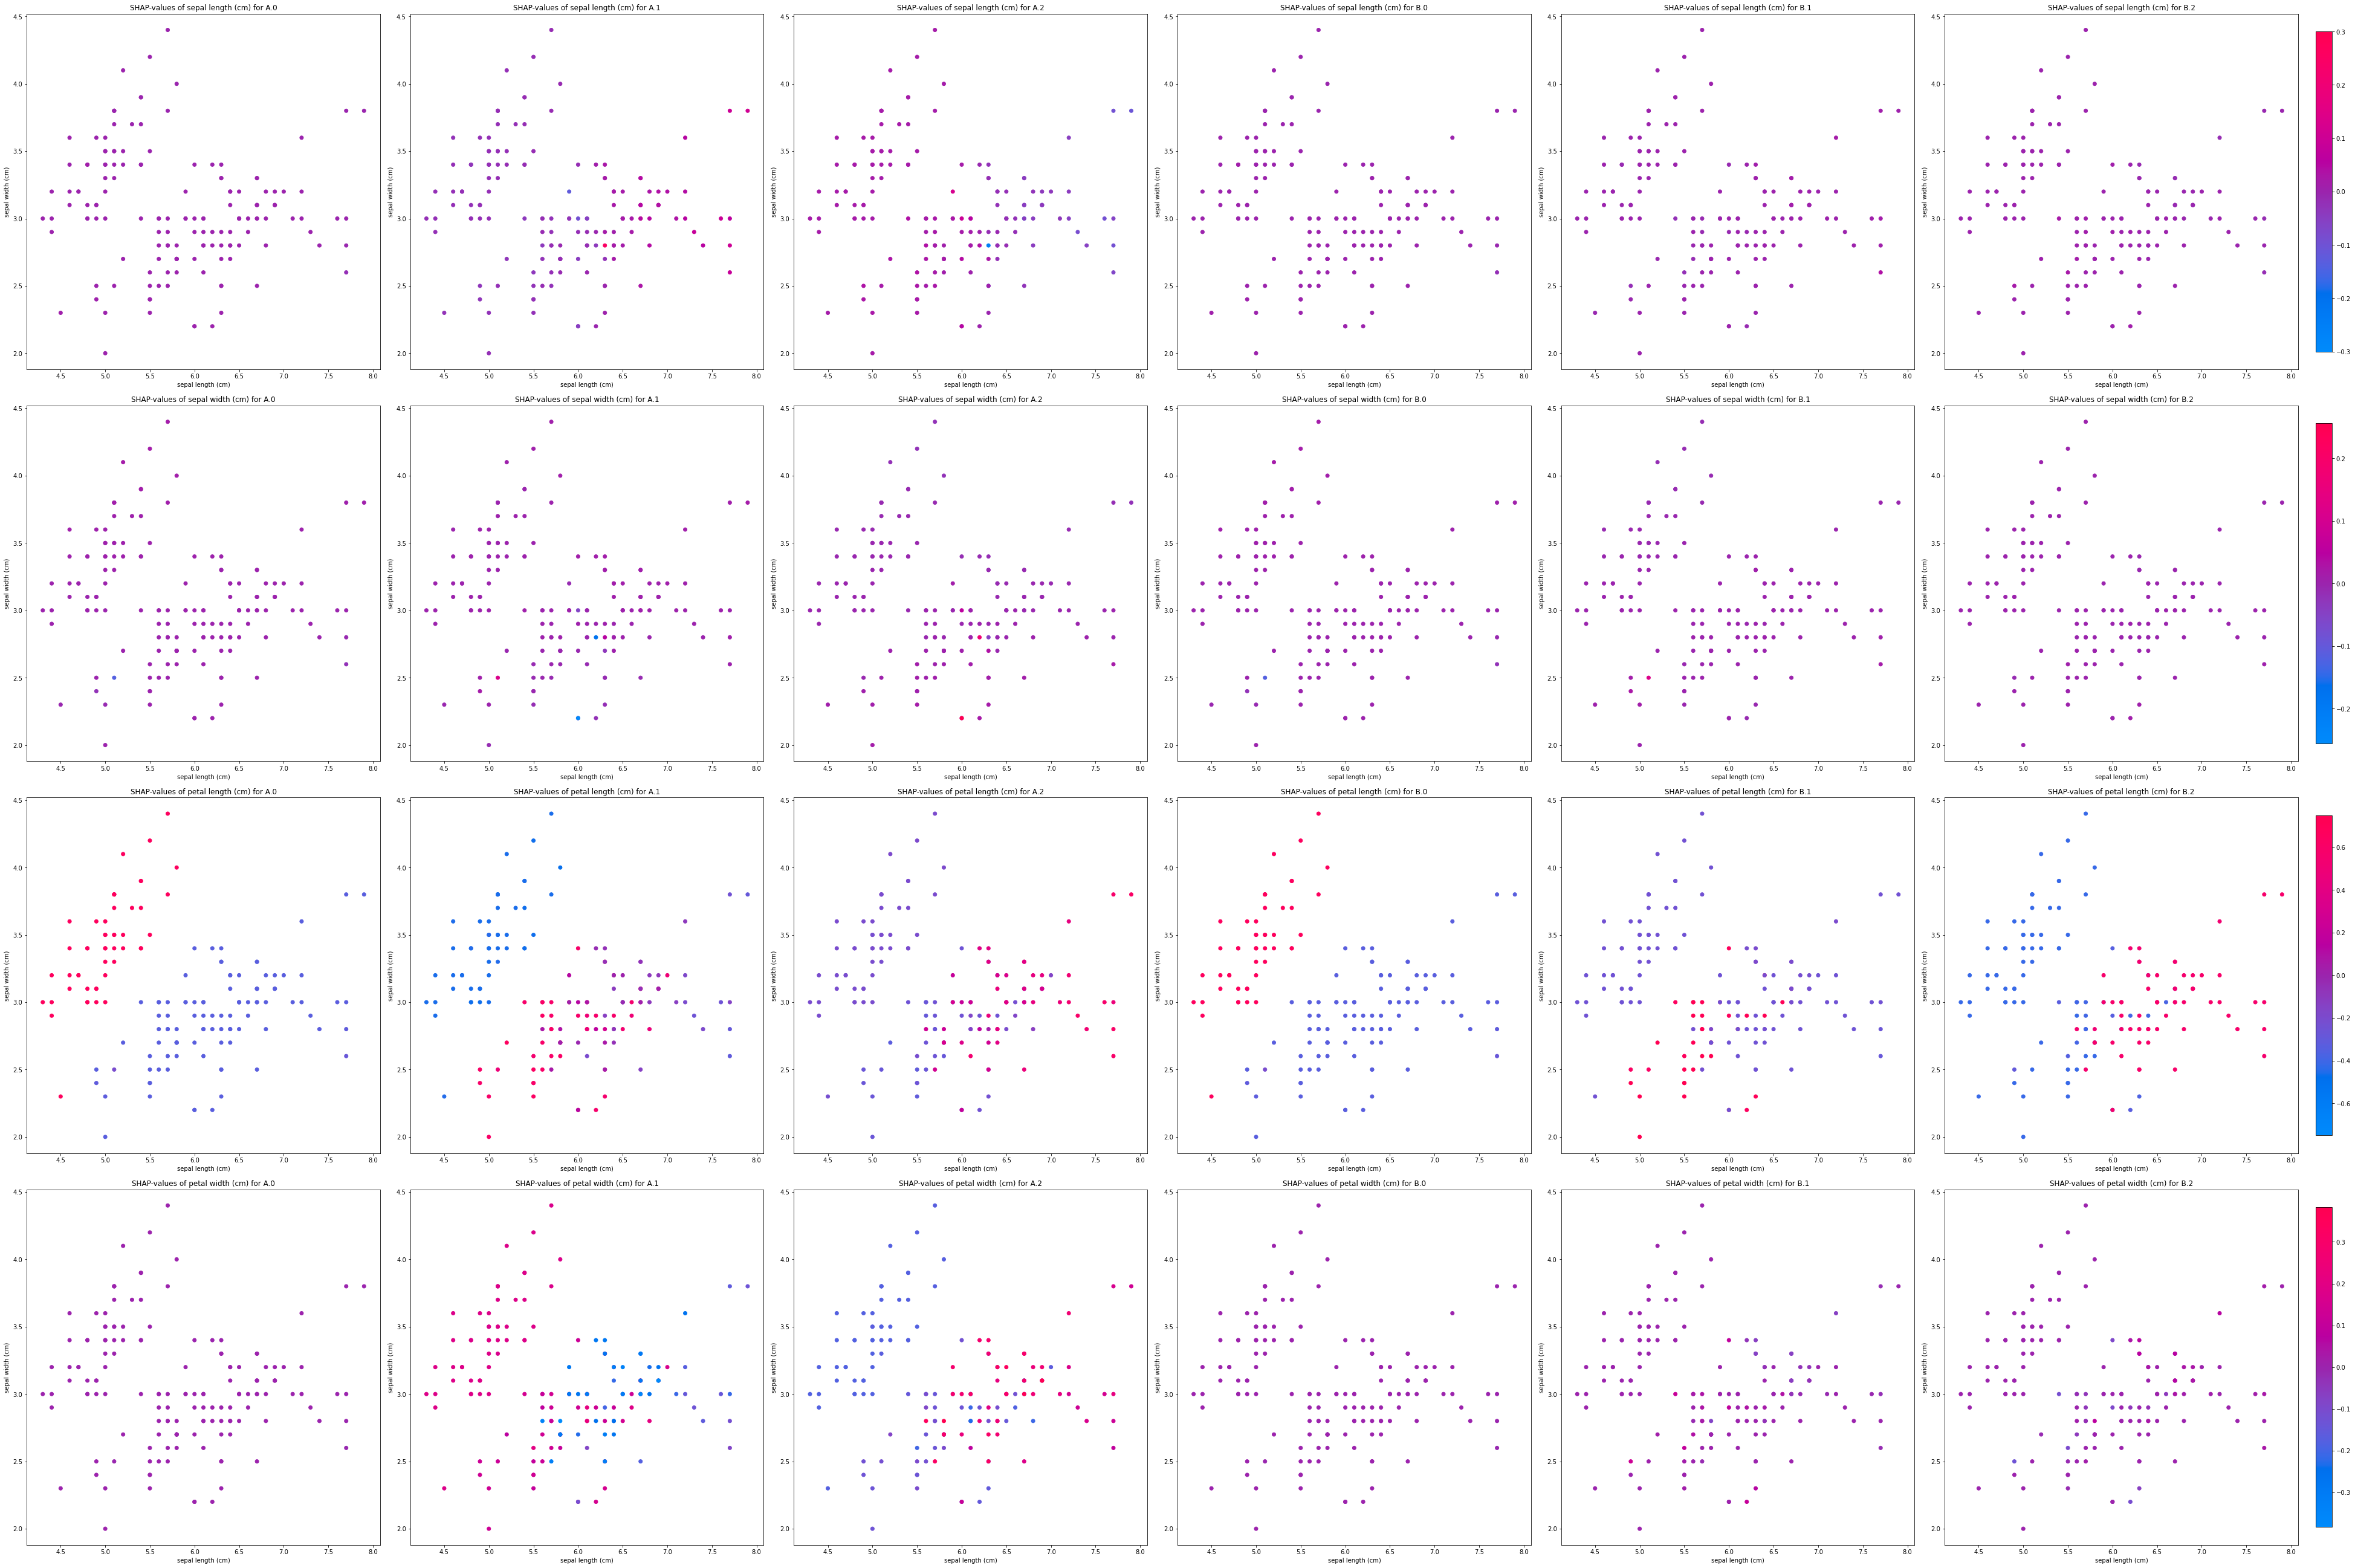

In [32]:
plot_2d(explanations.indiv.labels.merged)

### Simple subtraction explanation

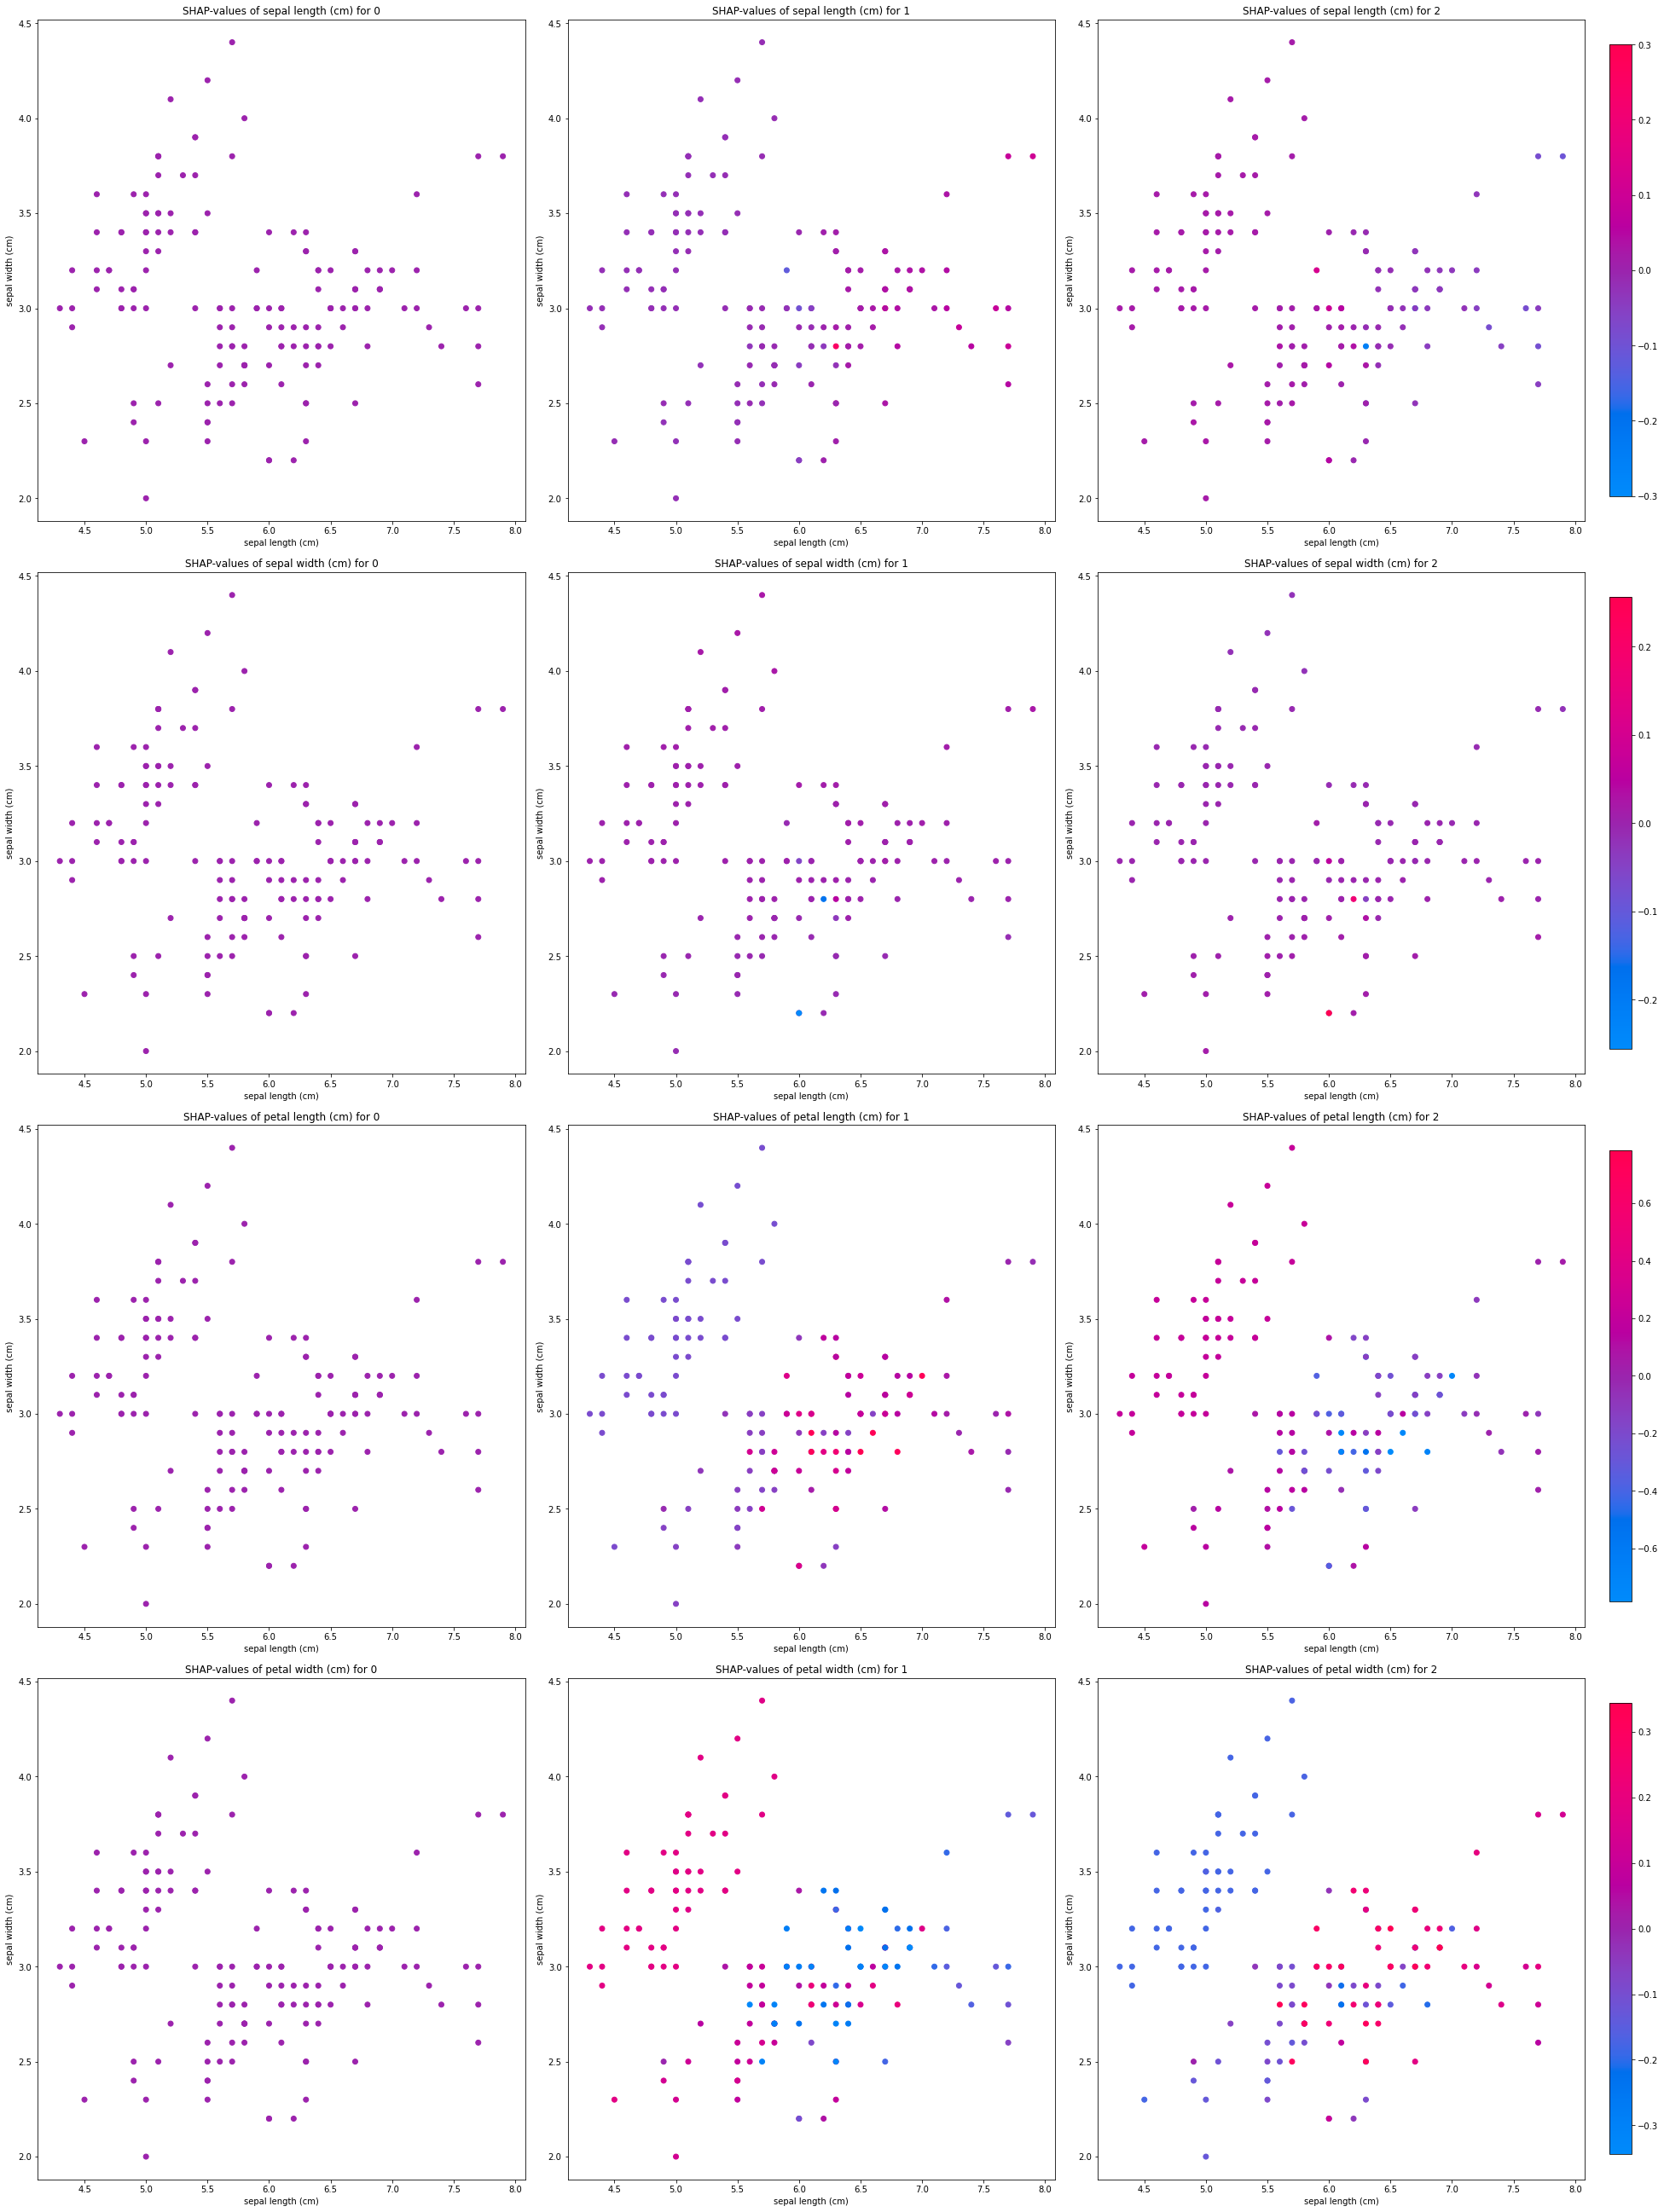

In [33]:
plot_2d(explanations.indiv_diff.labels)

### Multiclass difference classifier explanations

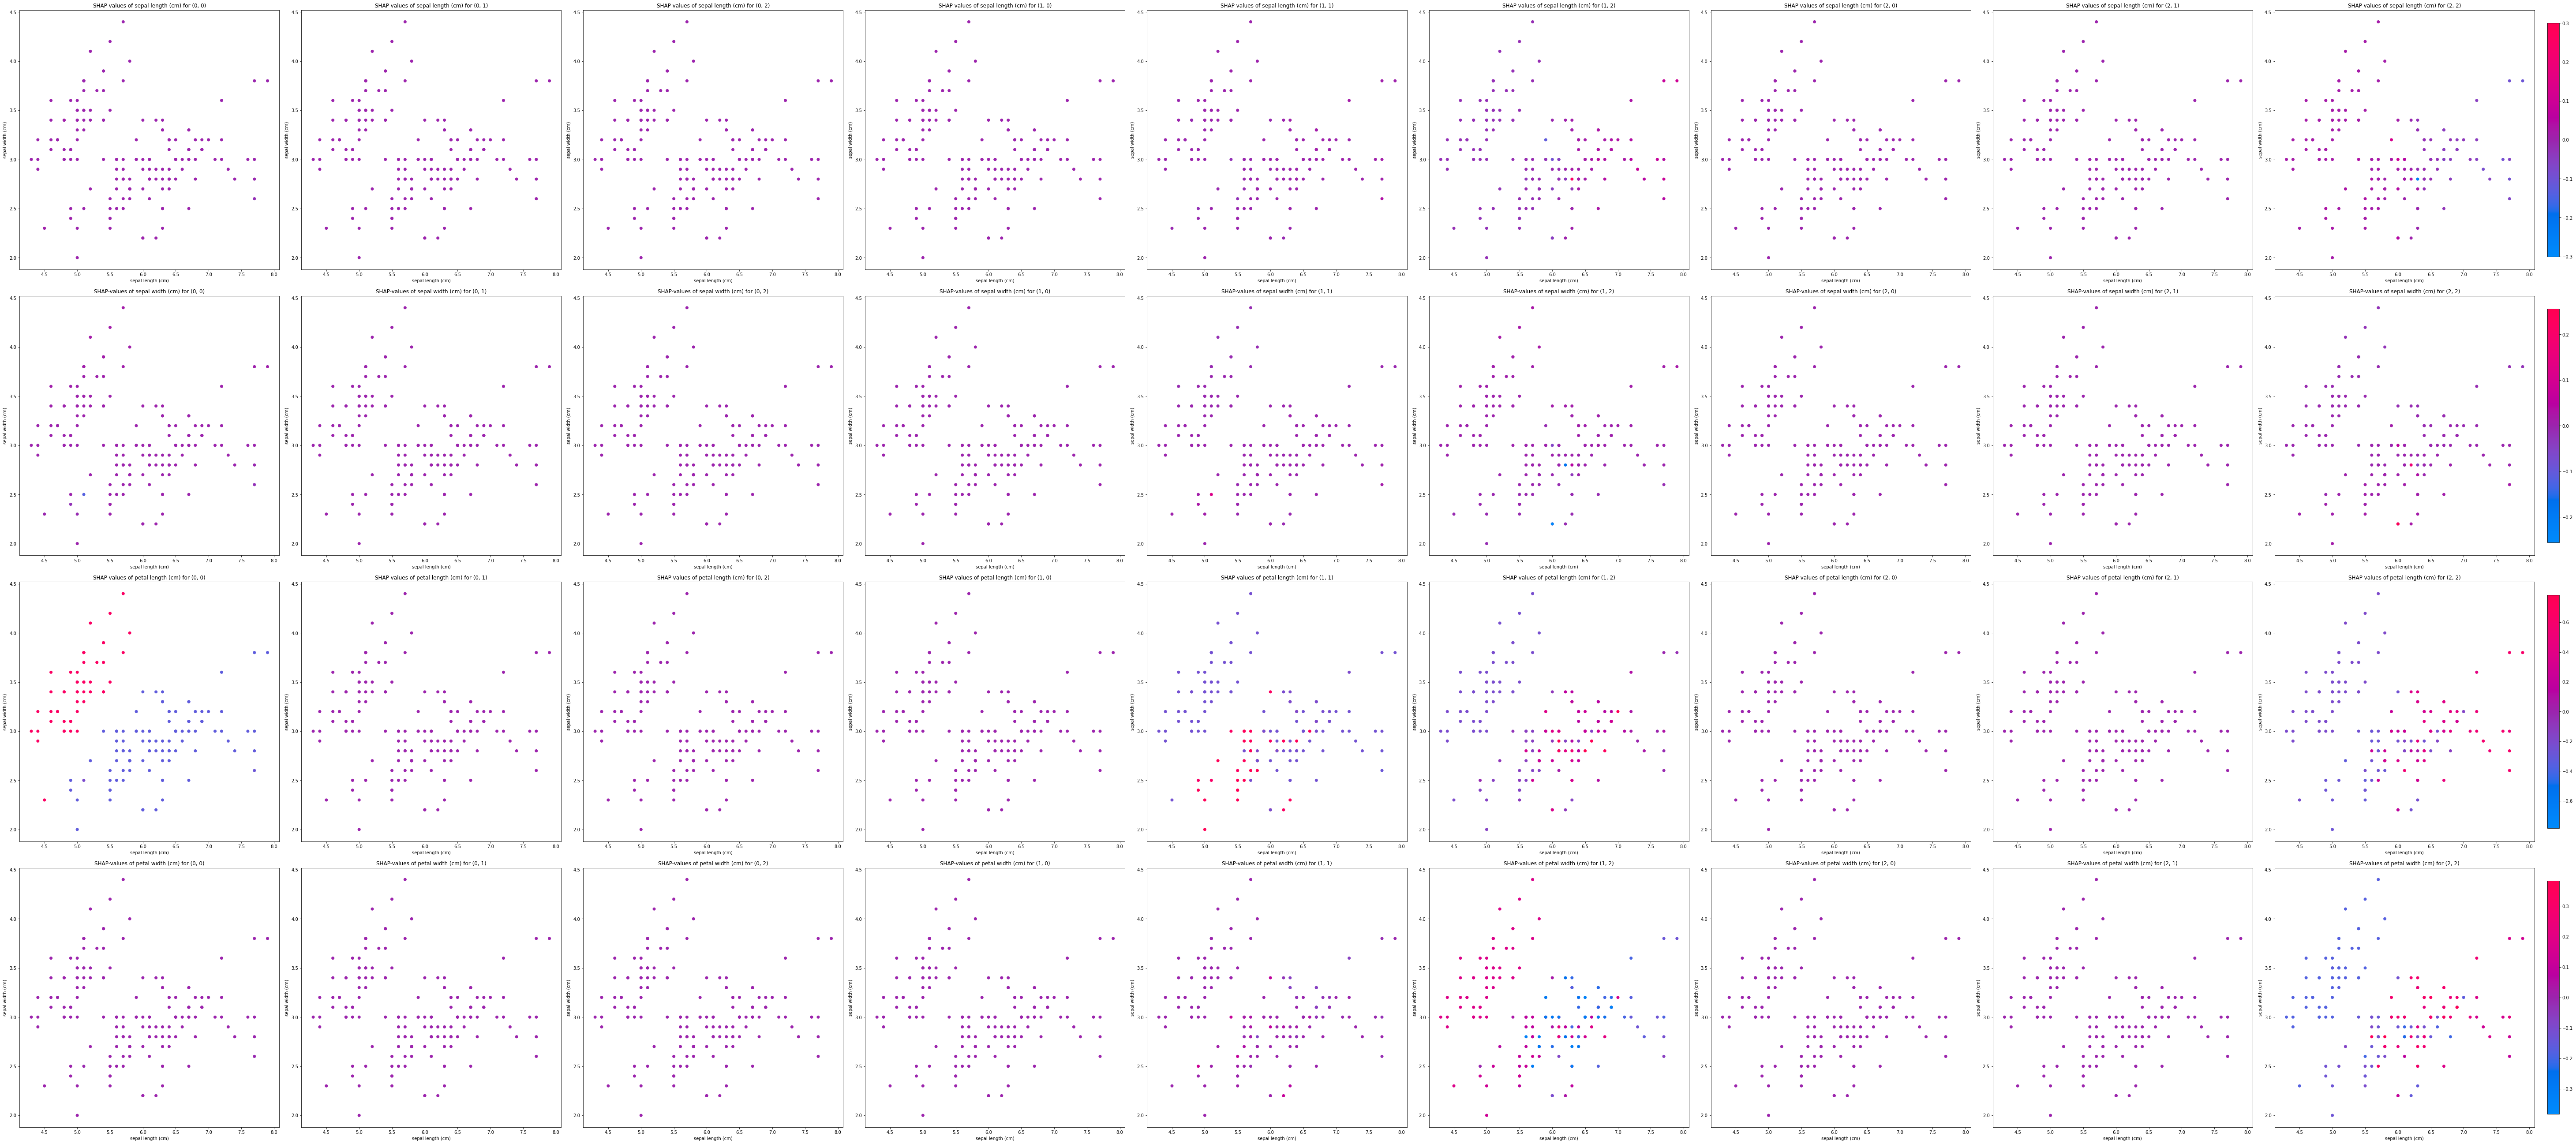

In [34]:
plot_2d(explanations.mclass_diff.labels)

## Feature importance

### Individual explanations

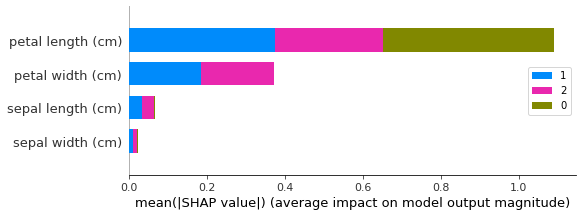

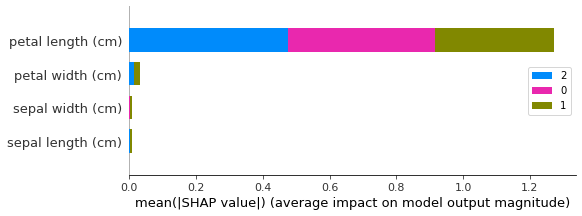

In [35]:
plot_feature_importance_bar(explanations.indiv.labels.A)
plot_feature_importance_bar(explanations.indiv.labels.B)

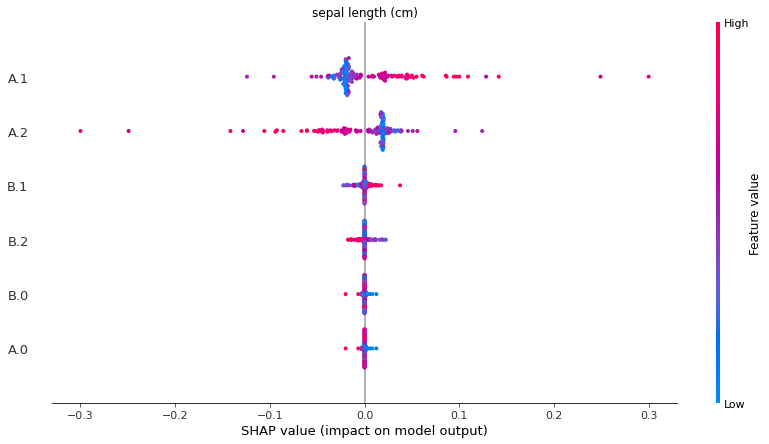

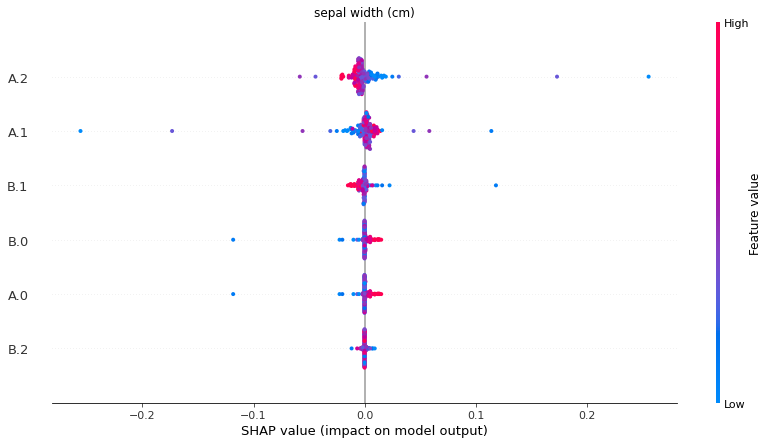

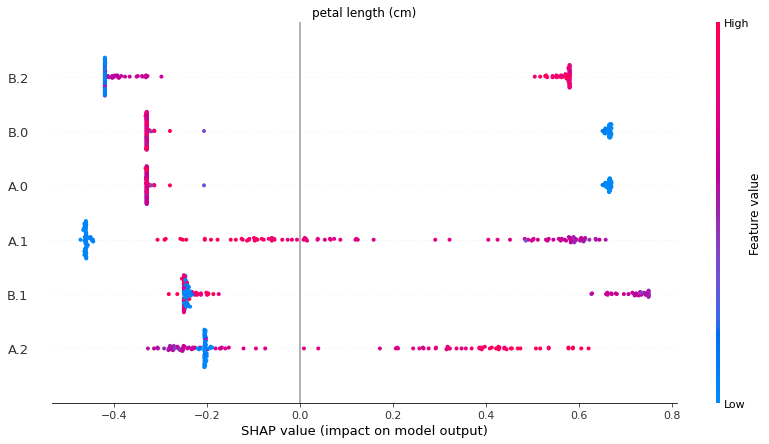

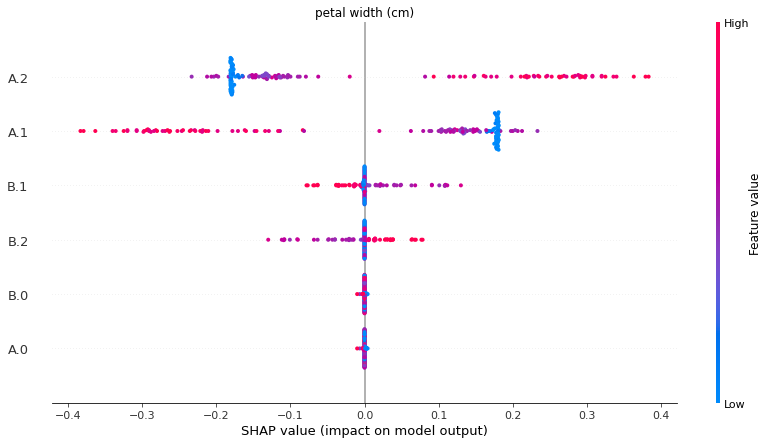

In [36]:
plot_feature_importance_scatter(explanations.indiv.labels.merged)

### Simple subtraction explanation

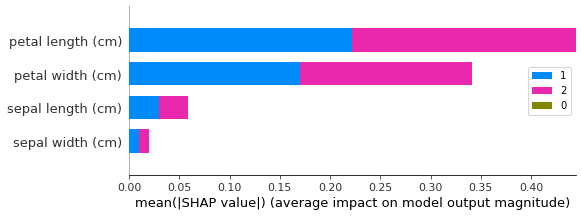

In [37]:
plot_feature_importance_bar(explanations.indiv_diff.labels)

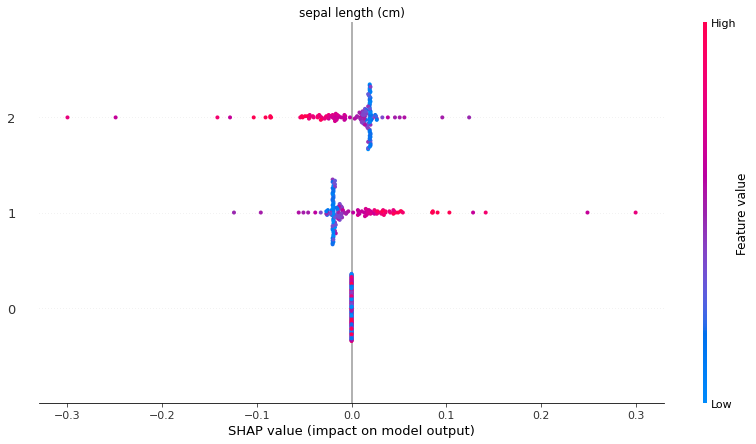

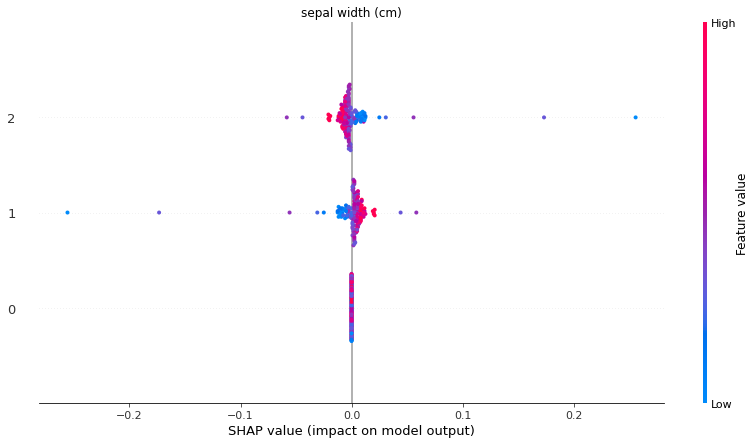

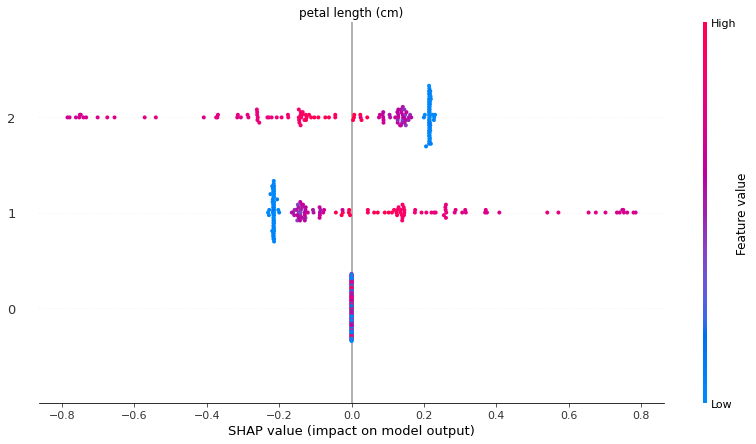

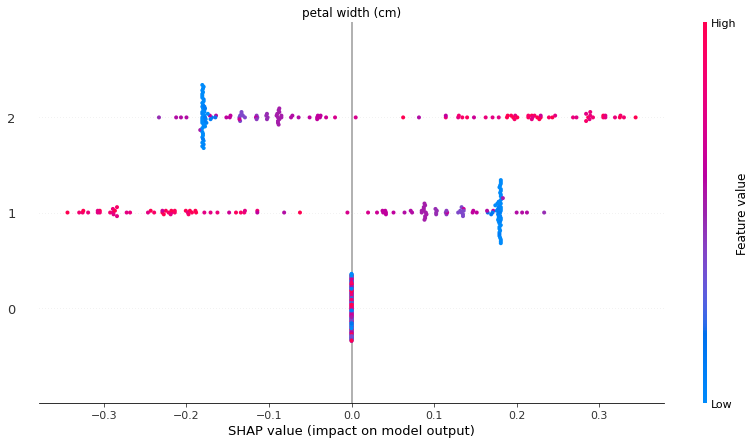

In [38]:
plot_feature_importance_scatter(explanations.indiv_diff.labels)

### Multiclass difference classifier explanations

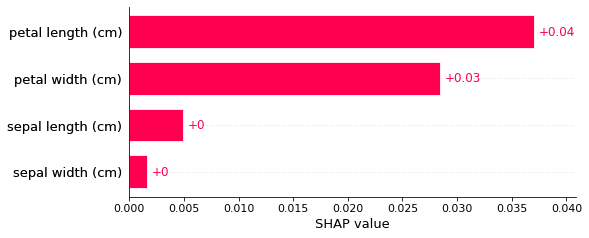

In [39]:
feature_order, feature_importance = calc_feature_order(explanations.mclass_diff.labels[:, :, comparer.difference_class_names])
plot_feature_importance_bar(feature_importance)

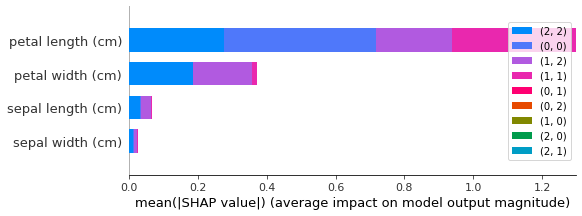

In [40]:
plot_feature_importance_bar(explanations.mclass_diff.labels)

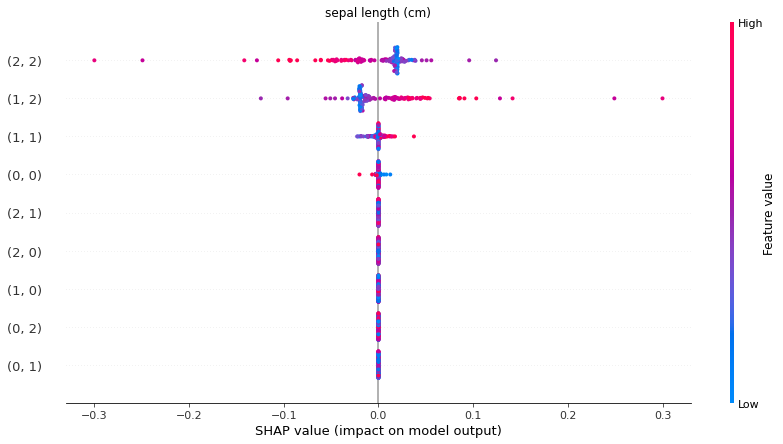

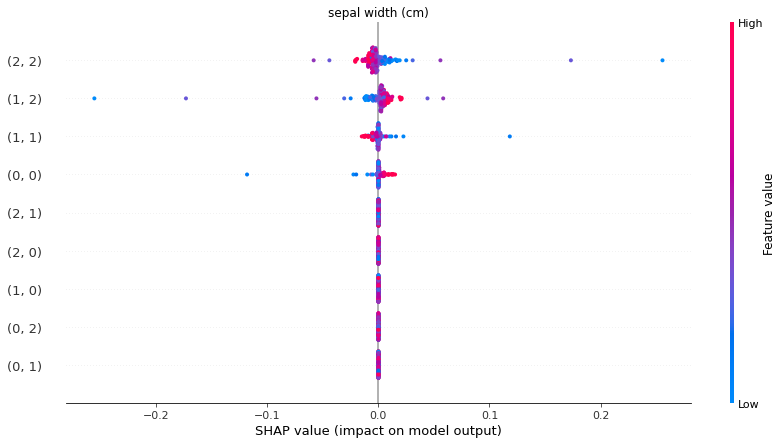

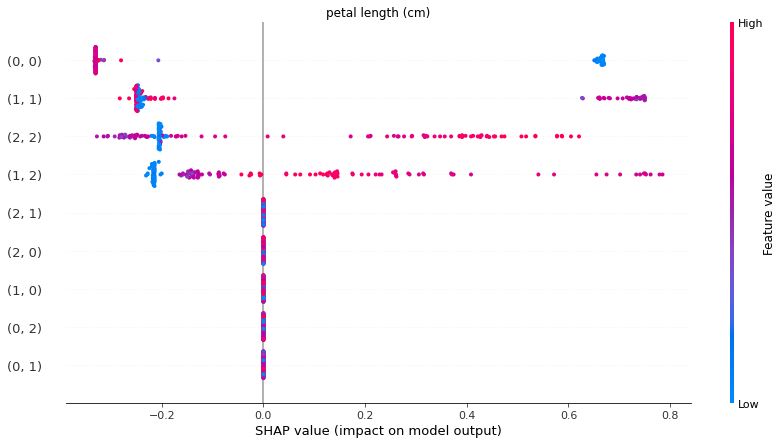

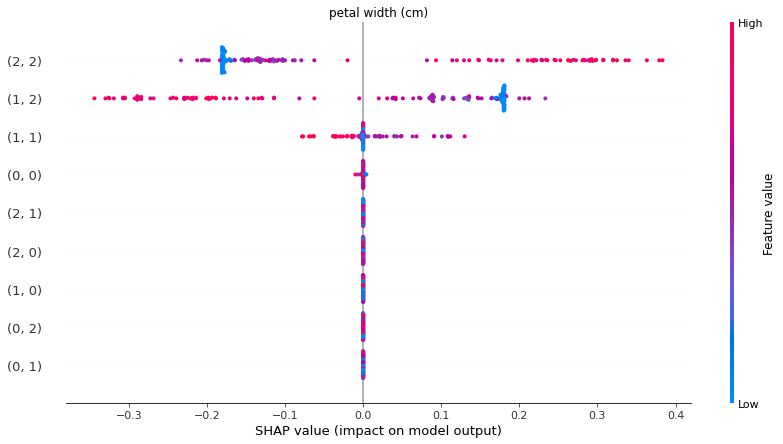

In [41]:
plot_feature_importance_scatter(explanations.mclass_diff.labels)

## Feature effects

### Individual explanations

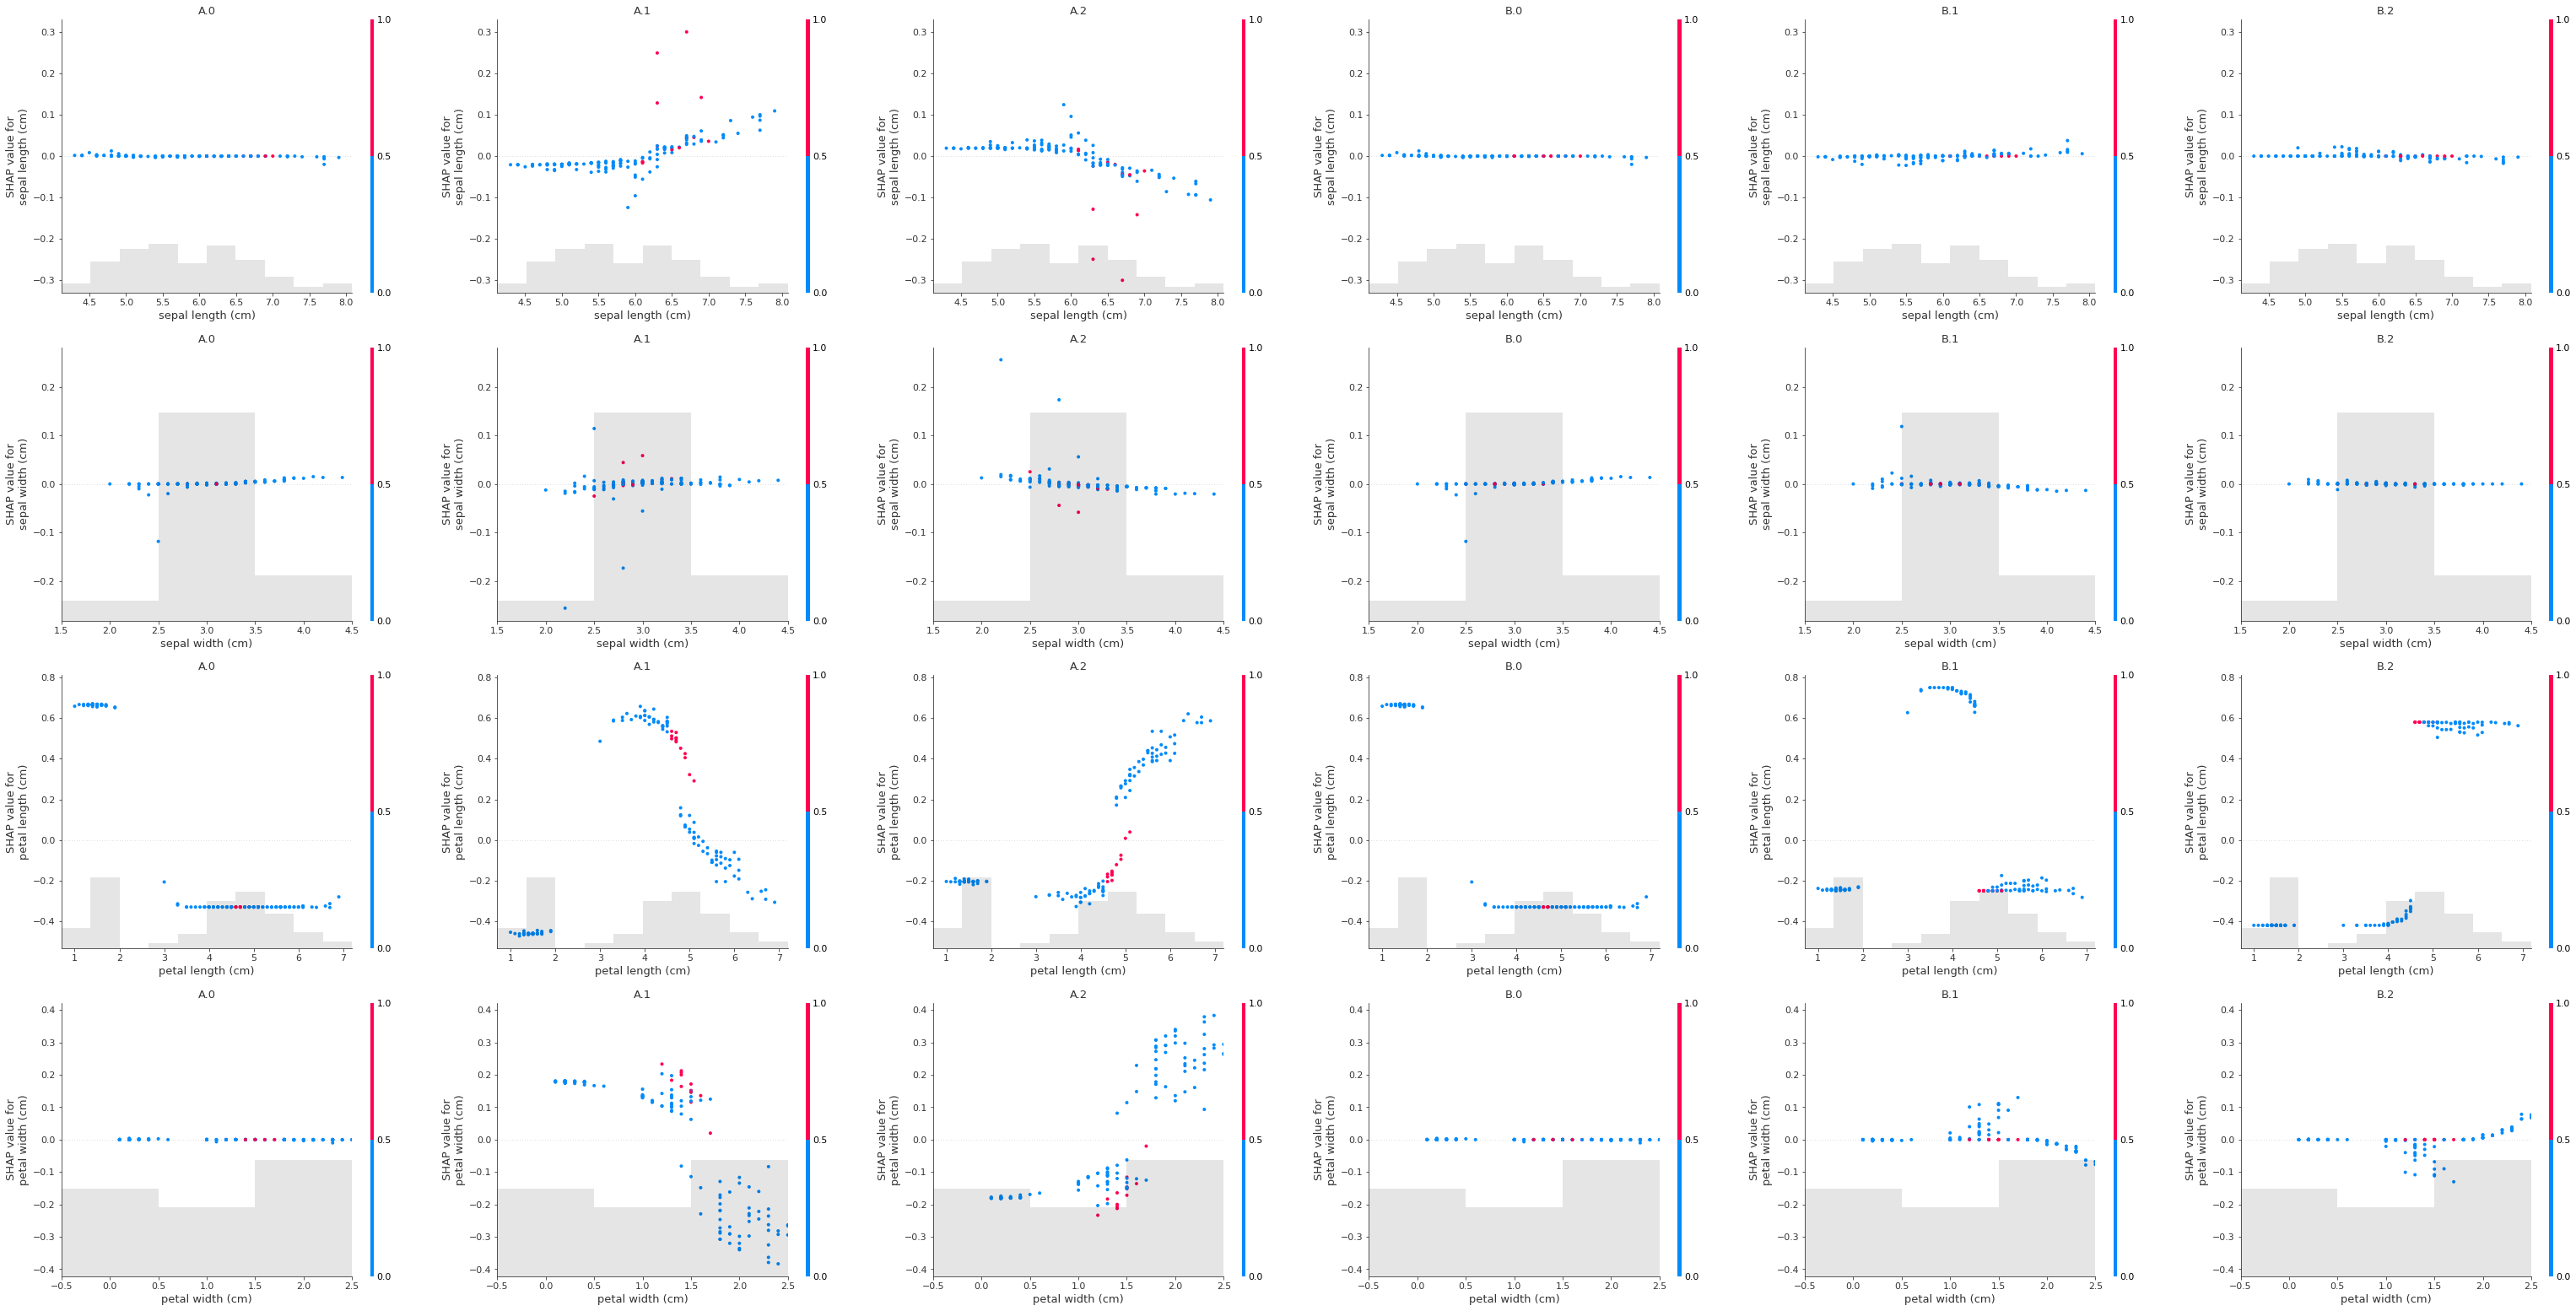

In [42]:
is_pred_diff = comparer.predict_bin_diff(explanations.data)
plot_feature_effects(explanations.indiv.labels.merged, color=is_pred_diff)

### Simple subtraction explanation

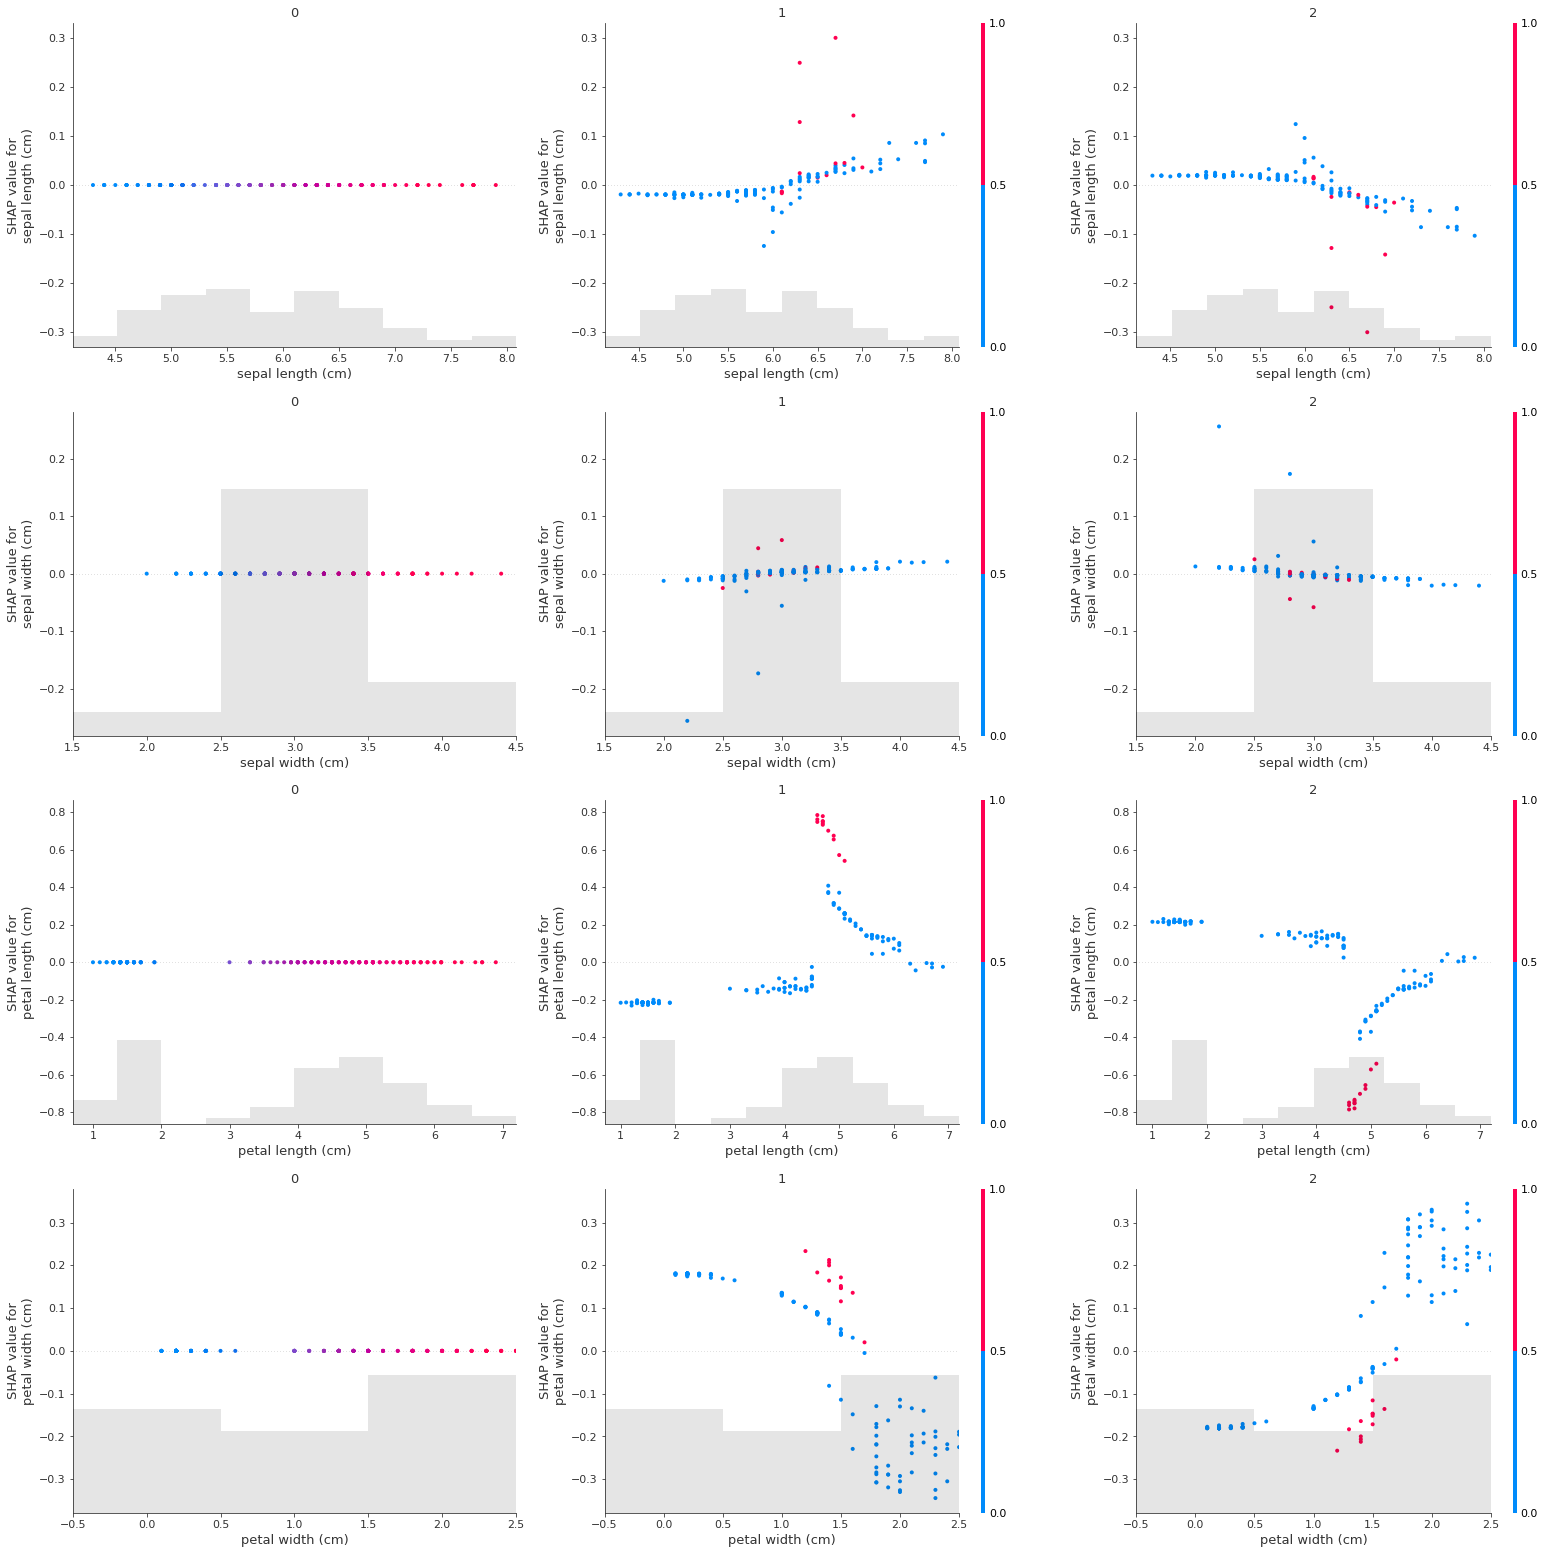

In [43]:
plot_feature_effects(explanations.indiv_diff.labels, color=is_pred_diff)

### Multiclass difference classifier explanations

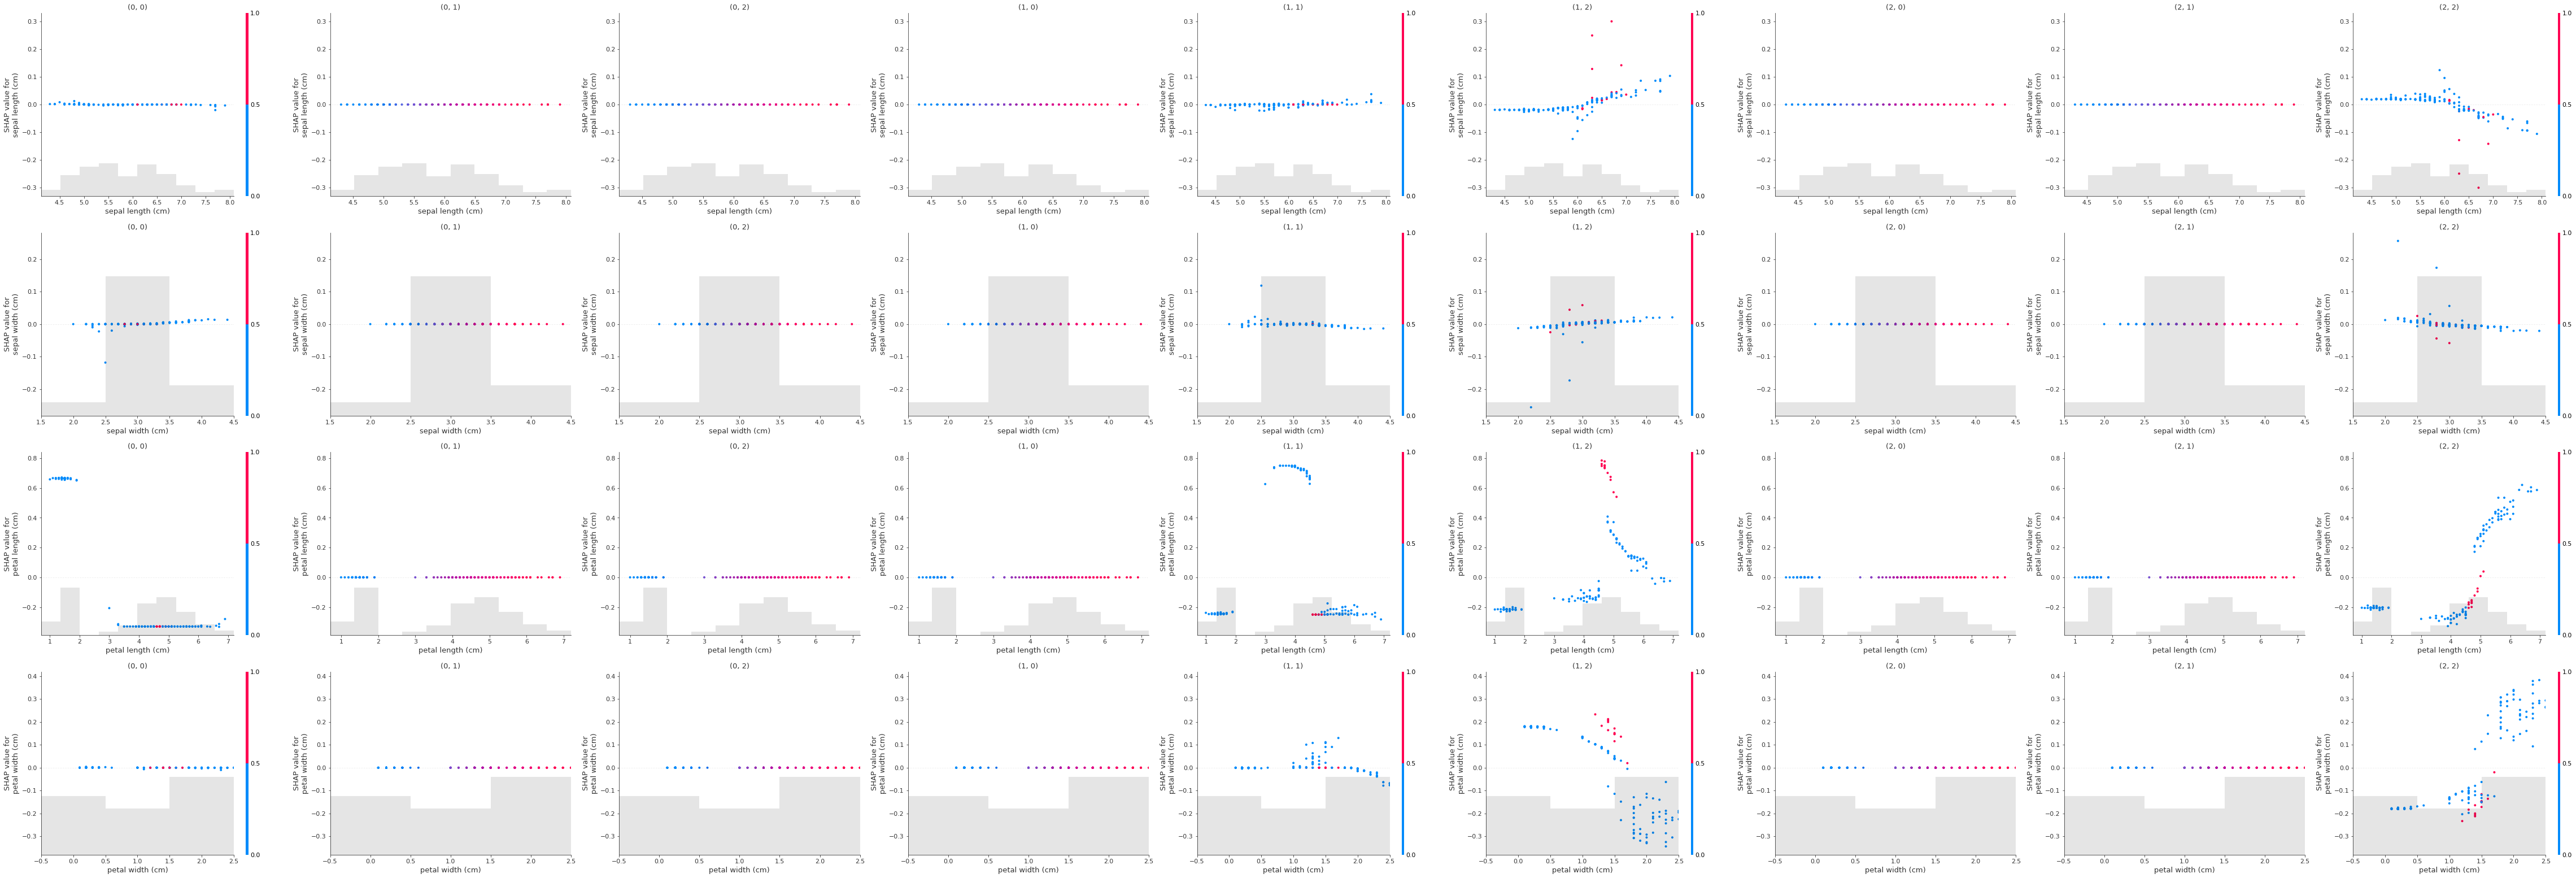

In [44]:
plot_feature_effects(explanations.mclass_diff.labels, color=is_pred_diff)

## Cluster instances

### Individual explanations

In [45]:
instance_order = calc_instance_order(explanations.merged)
plot_forces(explanations.indiv.labels.merged, instance_order=instance_order)

### Simple subtraction explanation

In [46]:
plot_forces(explanations.indiv_diff.labels, instance_order=instance_order)

### Multiclass difference classifier explanations

In [47]:
plot_forces(explanations.mclass_diff.labels[:, :, comparer.difference_class_names], instance_order=instance_order)